In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load datasets
fear = pd.read_csv('/content/drive/MyDrive/fear_greed_index.csv')
hist = pd.read_csv('/content/drive/MyDrive/historical_data.csv')

fear.head(), hist.head()


(    timestamp  value classification        date
 0  1517463000     30           Fear  2018-02-01
 1  1517549400     15   Extreme Fear  2018-02-02
 2  1517635800     40           Fear  2018-02-03
 3  1517722200     24   Extreme Fear  2018-02-04
 4  1517808600     11   Extreme Fear  2018-02-05,
                                       Account  Coin  Execution Price  \
 0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
 1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
 2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
 3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
 4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   
 
    Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
 0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
 1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
 2       144.09   1150.63  BUY 

In [2]:
import pandas as pd

# --- CLEAN FEAR-GREED DATA ---
fear['date'] = pd.to_datetime(fear['date'])
fear = fear[['date', 'value', 'classification']]   # keep only useful columns
fear.rename(columns={'value': 'fear_greed_value',
                     'classification': 'fear_greed_label'}, inplace=True)


# --- CLEAN HYPERLIQUID DATA ---
hist['Timestamp'] = pd.to_datetime(hist['Timestamp'] / 1000, unit='s')

# extract date for merging later
hist['date'] = hist['Timestamp'].dt.date
hist['date'] = pd.to_datetime(hist['date'])

# keep only essential columns
hist_clean = hist[['date', 'Execution Price', 'Size USD', 'Side', 'Fee', 'Closed PnL']]


In [3]:
# Daily metrics from historical trader data
daily = hist_clean.groupby('date').agg({
    'Closed PnL': 'sum',          # total profit/loss
    'Size USD': 'sum',            # total volume traded
    'Execution Price': 'mean',    # avg trade price
    'Fee': 'sum'                  # total fees paid
}).reset_index()

daily.rename(columns={
    'Closed PnL': 'daily_pnl',
    'Size USD': 'daily_volume',
    'Execution Price': 'avg_price',
    'Fee': 'daily_fees'
}, inplace=True)

daily.head()


,date,daily_pnl,daily_volume,avg_price,daily_fees
0,2023-03-28,0.000000e+00,4.770000e+02,1898.133333,0.000000
1,2023-11-14,1.555034e+02,1.155543e+07,10454.871036,2794.570654
2,2024-03-09,1.769655e+05,3.940677e+07,9771.897315,6812.781233
3,2024-07-03,1.587424e+05,2.184323e+07,2663.132338,8743.877486
4,2024-10-27,3.189461e+06,1.039478e+08,5367.503277,21539.462735


In [4]:
merged = pd.merge(daily, fear, on='date', how='left')

merged.head()


,date,daily_pnl,daily_volume,avg_price,daily_fees,fear_greed_value,fear_greed_label
0,2023-03-28,0.000000e+00,4.770000e+02,1898.133333,0.000000,59.0,Greed
1,2023-11-14,1.555034e+02,1.155543e+07,10454.871036,2794.570654,69.0,Greed
2,2024-03-09,1.769655e+05,3.940677e+07,9771.897315,6812.781233,84.0,Extreme Greed
3,2024-07-03,1.587424e+05,2.184323e+07,2663.132338,8743.877486,50.0,Neutral
4,2024-10-27,3.189461e+06,1.039478e+08,5367.503277,21539.462735,74.0,Greed


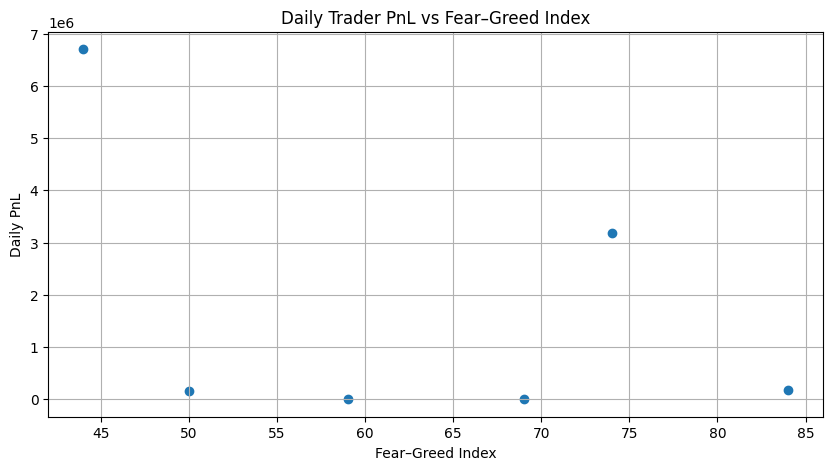

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.scatter(merged['fear_greed_value'], merged['daily_pnl'])
plt.xlabel("Fear–Greed Index")
plt.ylabel("Daily PnL")
plt.title("Daily Trader PnL vs Fear–Greed Index")
plt.grid(True)
plt.show()


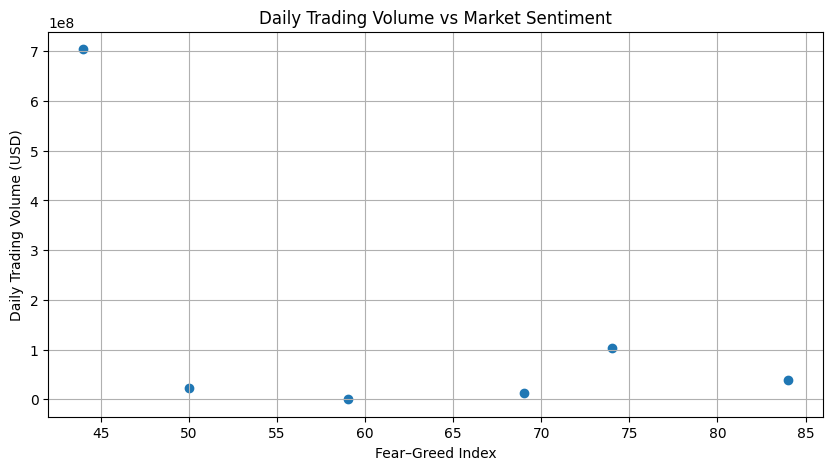

In [6]:
plt.figure(figsize=(10,5))
plt.scatter(merged['fear_greed_value'], merged['daily_volume'])
plt.xlabel("Fear–Greed Index")
plt.ylabel("Daily Trading Volume (USD)")
plt.title("Daily Trading Volume vs Market Sentiment")
plt.grid(True)
plt.show()


In [7]:
merged[['daily_pnl', 'daily_volume', 'avg_price', 'fear_greed_value']].corr()


,daily_pnl,daily_volume,avg_price,fear_greed_value
daily_pnl,1.000000,0.830236,-0.001137,-0.452662
daily_volume,0.830236,1.000000,0.457517,-0.572090
avg_price,-0.001137,0.457517,1.000000,0.194022
fear_greed_value,-0.452662,-0.572090,0.194022,1.000000


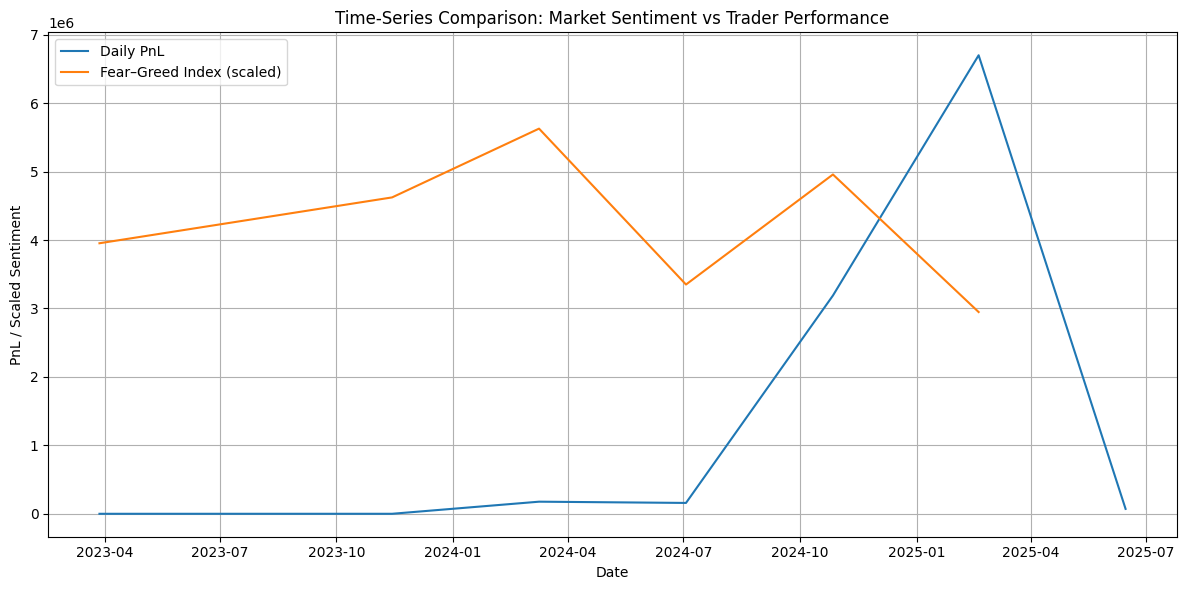

In [8]:
plt.figure(figsize=(12,6))

# Plot Daily PnL
plt.plot(merged['date'], merged['daily_pnl'], label="Daily PnL")

# Plot Fear–Greed Index (scaled to compare on same graph)
plt.plot(merged['date'], merged['fear_greed_value'] * merged['daily_pnl'].max() / 100,
         label="Fear–Greed Index (scaled)")

plt.xlabel("Date")
plt.ylabel("PnL / Scaled Sentiment")
plt.title("Time-Series Comparison: Market Sentiment vs Trader Performance")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


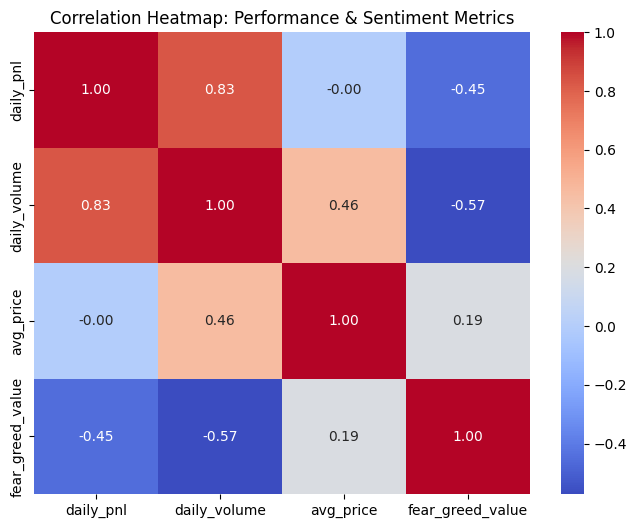

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = merged[['daily_pnl','daily_volume','avg_price','fear_greed_value']].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap: Performance & Sentiment Metrics")
plt.show()
